name: P
name: J
name: K
name: d
name: \Pi
name: \lambda
name: \pi


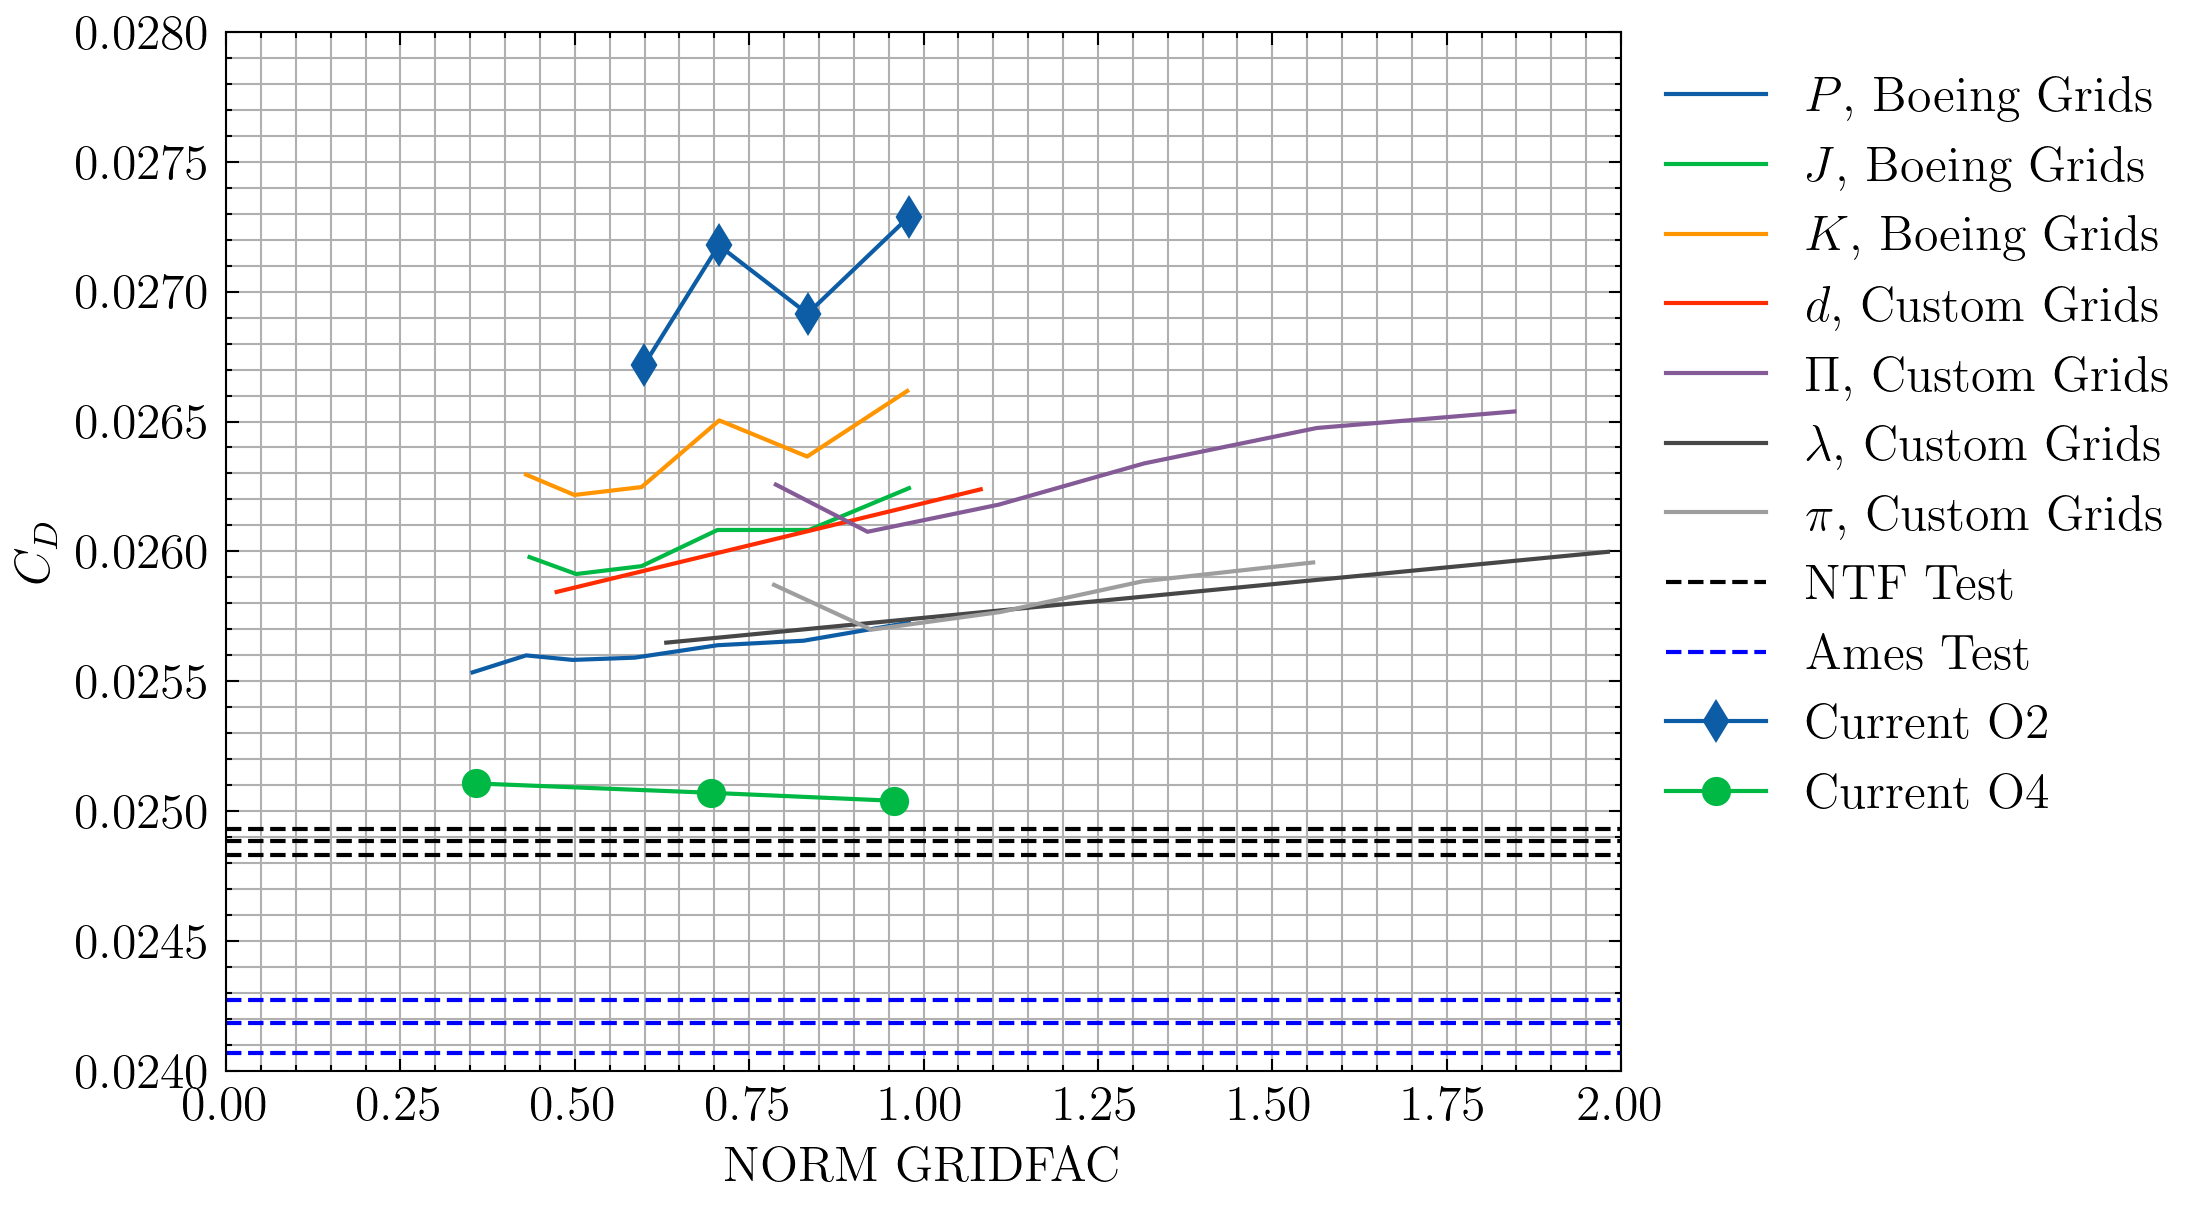

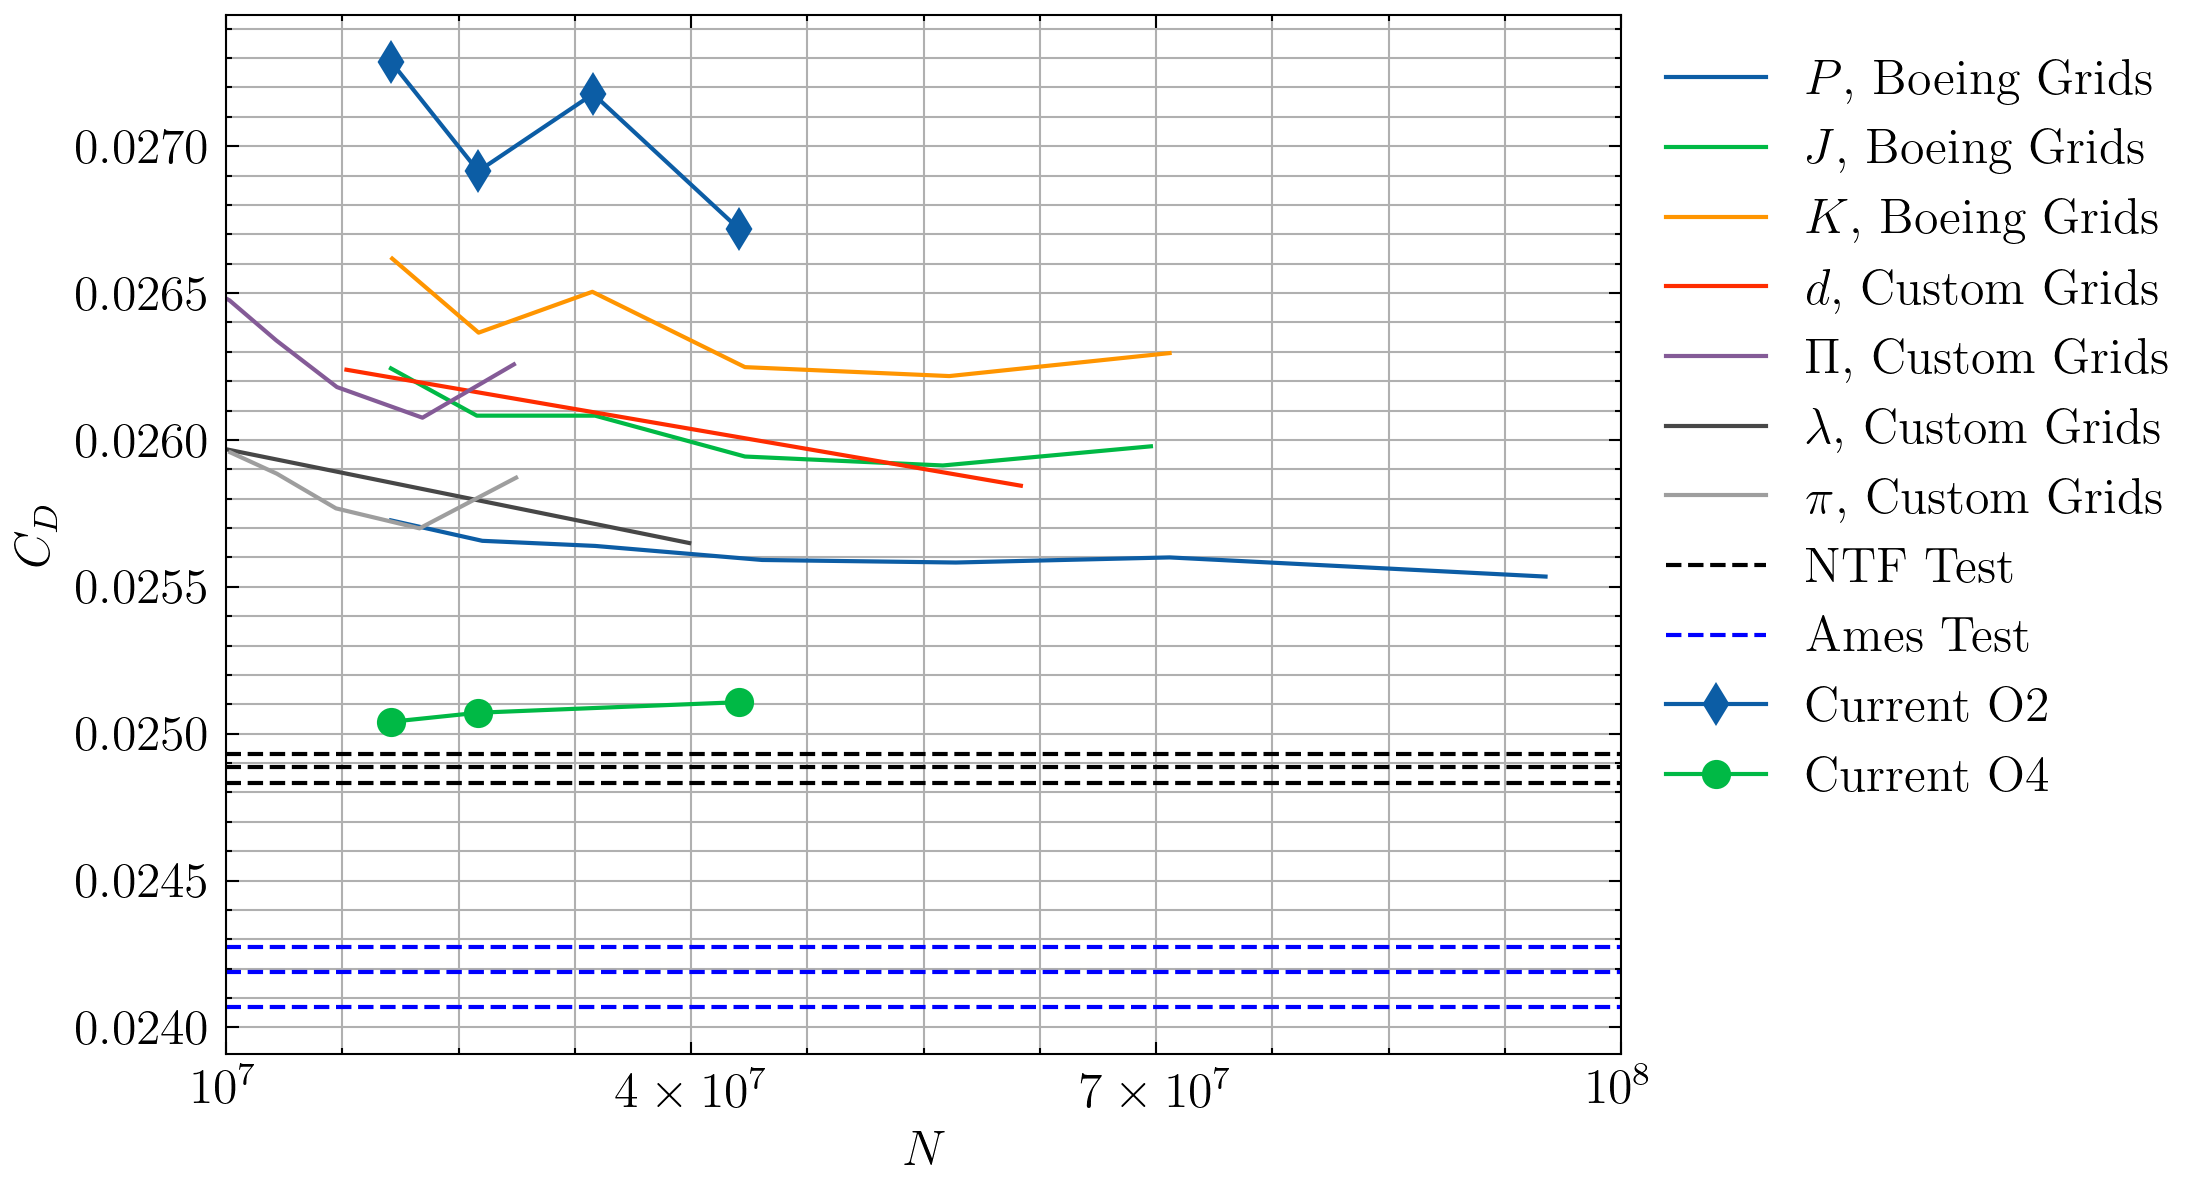

In [ ]:
import numpy as np
from LogErrLoader import LoadDNDSLogErr
import os

meshSizes = {"T": 20657615, "C": 26271819, "M": 33683206, "F": 43126748}
base = "CRM_2_Boeing"
O2_set = ["T", "C", "M", "F"]
O4_set = ["T", "C", "F"]

import scienceplots
import matplotlib.pyplot as plt
import matplotlib
plt.style.use(["science"])

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
font = {"size": 12}
matplotlib.rc("font", **font)
lwc = 0.5
msc = 5
markEvery = 200
fmt = "pdf"


def get_tail_value(v: np.ndarray, n):
    return np.array(v)[-1 - n : -1].mean()


def get_tail_gap(v: np.ndarray, n):
    return np.array(v)[-1 - n : -1].max() - np.array(v)[-1 - n : -1].min()


ntail = 500


def get_results(set: list[str], prefix: str):
    files = [f"{prefix}{meshCode}_Dri_.log" for meshCode in set]
    data = {}
    for i, file in enumerate(files):
        data[set[i]] = LoadDNDSLogErr(os.path.join(base, file))
    results = {}
    results["meshSizes"] = np.array([meshSizes[k] for k in set])
    results["CD"] = np.array([get_tail_value(data[k]["CD"], ntail) for k in set])
    results["CL"] = np.array([get_tail_value(data[k]["CL"], ntail) for k in set])
    results["CLgap"] = np.array([get_tail_gap(data[k]["CL"], ntail) for k in set])
    results["AoA"] = np.array([get_tail_value(data[k]["AoA"], ntail) for k in set])
    return results


O2_results = get_results(O2_set, "O2_")
O4_results = get_results(O4_set, "O4_")

from dpw6data import *

data14_b = getData_fig14_b()
data14_c = getData_fig14_c()
data14_test = getData_fig14_test()


import itertools

plt.figure(101, figsize=(6, 4.5), dpi=300)
plt.figure(102, figsize=(6, 4.5), dpi=300)

grid_size_base = 2e7

def GFO2_to_norm_GF(gf: np.ndarray):
    return ((gf ** (-3./2.)) / grid_size_base) ** (-2./3.)

for name, data in data14_b.items():
    print(f"name: {name}")
    GFNorm = GFO2_to_norm_GF(data[0])
    plt.figure(101)
    plt.plot(GFNorm, data[1], label=f"${name}$, Boeing Grids")
    plt.figure(102)
    plt.plot(data[0] ** (-3.0 / 2.0), data[1], label=f"${name}$, Boeing Grids")
for name, data in data14_c.items():
    print(f"name: {name}")
    GFNorm = GFO2_to_norm_GF(data[0])
    plt.figure(101)
    plt.plot(GFNorm, data[1], label=f"${name}$, Custom Grids")
    plt.figure(102)
    plt.plot(data[0] ** (-3.0 / 2.0), data[1], label=f"${name}$, Custom Grids")
for name, data in data14_test.items():
    c = "k" if name == "NTF Test" else "b"
    for i, y in enumerate(data):
        plt.figure(101)
        plt.plot([0, 2], [y, y], label=name if i == 0 else None, ls="--", c=c)
        plt.figure(102)
        plt.plot([0, 1e8], [y, y], label=name if i == 0 else None, ls="--", c=c)

plt.figure(101)
plt.plot((O2_results["meshSizes"] / grid_size_base) ** (-2.0 / 3), O2_results["CD"], label="Current O2", marker = "d",)
plt.plot(
    (O4_results["meshSizes"] / grid_size_base)** (-4.0 / 3),
    O4_results["CD"],
    label="Current O4",
    marker = "o",
)
plt.figure(102)
plt.plot(O2_results["meshSizes"], O2_results["CD"], label="Current O2", marker = "d")
plt.plot(O4_results["meshSizes"], O4_results["CD"], label="Current O4", marker = "o")

plt.figure(101)
plt.xlim((0, 2))
plt.ylim((0.024, 0.028))
plt.grid(True, which="both")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.xlabel("NORM GRIDFAC")
plt.ylabel("$C_D$")

f = plt.figure(102)
plt.grid(True, which="both")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.xlabel("$N$")
plt.ylabel("$C_D$")
# plt.xscale("log")
plt.xlim([1e7, 1e8])
plt.xticks(np.linspace(1e7, 1e8, 4))
plt.gca().xaxis.set_major_formatter(
    matplotlib.ticker.LogFormatterSciNotation(labelOnlyBase=False, minor_thresholds=(3, 2))
)


plt.figure(101)
plt.savefig(f"crm_BoeingSeries_CDGF.{fmt}")
plt.figure(102)
plt.savefig(f"crm_BoeingSeries_CDGS.{fmt}")
plt.show()

In [2]:
CL_inters = {}
CL_maxes = {}

NTF_cd = data14_test["NTF Test"][1]

def get_linear_reg(xs: np.ndarray, ys: np.ndarray):
    xsv = np.concat([xs.reshape((-1, 1)), np.ones((xs.size, 1))], axis = 1)
    return np.linalg.lstsq(xsv, ys)[0]


for name, data in itertools.chain(data14_b.items(), data14_c.items()):
    fit = get_linear_reg(np.array(data[0]), np.array(data[1]))
    CL_inters[name] = fit[1]
    CL_maxes[name] = np.array(data[1]).max()
    print(f"name: {name} {fit}")

O2_fit = get_linear_reg(O2_results["meshSizes"] ** (-2.0 / 3), O2_results["CD"])
CL_inters["O2"] = O2_fit[1]
CL_maxes["O2"] = O2_results["CD"].max()
print(f"O2 {O2_fit}")
O4_fit = get_linear_reg(O4_results["meshSizes"] ** (-4.0 / 3), O4_results["CD"])
CL_inters["O4"] = O4_fit[1]
CL_maxes["O4"] = O4_results["CD"].max()
print(f"O4 {O4_fit}")
CL_inters = CL_inters

print("\n Intercept Errors: ")
for name, CL in CL_inters.items():
    print(f"{name:16} err = {(CL - NTF_cd) * 1e4:.2f}")
print("\n Intercept Rel Errors: ")
for name, CL in CL_inters.items():
    print(f"{name:16} err rel = {(CL - NTF_cd) / NTF_cd:.2e}")
print("\n === Form: \n| Case Name | CD intercept vs NTF test (counts) | CD intercept vs NTF test (relative) |")
print("|---|---|---|")
for name, CL in CL_inters.items():
    print(f"|${name:16}$|{(CL - NTF_cd) * 1e4:.2f}|\\({(CL - NTF_cd) / NTF_cd * 100:.1f}\\%\\) |")

print("\n Cal Errors: ")
for name, CL in CL_maxes.items():
    print(f"{name:16} err = {(CL - NTF_cd) * 1e4:.2f}")
print("\n Cal Rel Errors: ")
for name, CL in CL_maxes.items():
    print(f"{name:16} err rel = {(CL - NTF_cd) / NTF_cd:.2e}")
    
print("\n === Form: \n| Case Name | CD worst vs NTF test (counts) | CD worst vs NTF test (relative) |")
print("|---|---|---|")
for name, CL in CL_maxes.items():
    print(f"|${name:16}$|{(CL - NTF_cd) * 1e4:.2f}|\\({(CL - NTF_cd) / NTF_cd * 100:.1f}\\%\\) |")

name: P [19.34655236  0.02545438]
name: J [3.95890425e+01 2.56776801e-02]
name: K [4.57392529e+01 2.59563844e-02]
name: d [4.78512342e+01 2.55363214e-02]
name: \Pi [2.85335194e+01 2.58240269e-02]
name: \lambda [19.07414386  0.02548562]
name: \pi [15.28330129  0.02559981]
O2 [8.29799327e+01 2.61461890e-02]
O4 [-6.04608362e+05  2.51476894e-02]

 Intercept Errors: 
P                err = 5.67
J                err = 7.91
K                err = 10.69
d                err = 6.49
\Pi              err = 9.37
\lambda          err = 5.99
\pi              err = 7.13
O2               err = 12.59
O4               err = 2.61

 Intercept Rel Errors: 
P                err rel = 2.28e-02
J                err rel = 3.18e-02
K                err rel = 4.30e-02
d                err rel = 2.61e-02
\Pi              err rel = 3.77e-02
\lambda          err rel = 2.41e-02
\pi              err rel = 2.86e-02
O2               err rel = 5.06e-02
O4               err rel = 1.05e-02

 === Form: 
| Case Name | CD in